# Imports

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

2025-01-20 14:11:10.004472: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-20 14:11:10.351653: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-20 14:11:10.456243: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-20 14:11:10.486712: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-20 14:11:10.781481: I tensorflow/core/platform/cpu_feature_guar

# Aux functions

In [2]:
def visualize_segmented_image(data, data_segmented, num_images, save=False, name=None, gray=False):
    """
    Displays images and their segmentations, with each pair stacked vertically and multiple pairs arranged horizontally.

    :param data: Image array from the Oxford-IIIT Pet Dataset.
    :param data_segmented: Array of segmentations.
    :param num_images: Number of image-segmentation pairs to be displayed.
    """

    plt.figure(figsize=(5 * num_images, 10))

    for i in range(num_images):

        indice = np.random.randint(0, len(data))

        # Imagem original
        plt.subplot(2, num_images, i + 1)
        if gray is True:
            plt.imshow(data[indice], cmap='gray')
        else:
            plt.imshow(data[indice])
        plt.title("Original Image")
        plt.axis("off")

        # Imagem segmentada
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(data_segmented[indice], cmap='gray')
        plt.title("Segmented Image")
        plt.axis("off")

    plt.tight_layout()
    if save is True:
        if name is None:
            print("Nome do arquivo não determinado.")
            raise(ValueError)
        
        diretorio = "imgs"
        os.makedirs(diretorio, exist_ok=True)
        caminho = os.path.join(diretorio, f"{name}.png")
        plt.savefig(caminho, dpi=300, bbox_inches='tight')
        
    plt.show()

# Loading dataset

In [3]:
with open('data.pkl', 'rb') as f:
    data = pickle.load(f)

with open('data_segmented.pkl', 'rb') as f:
    data_segmented = pickle.load(f)

Viewing some examples:

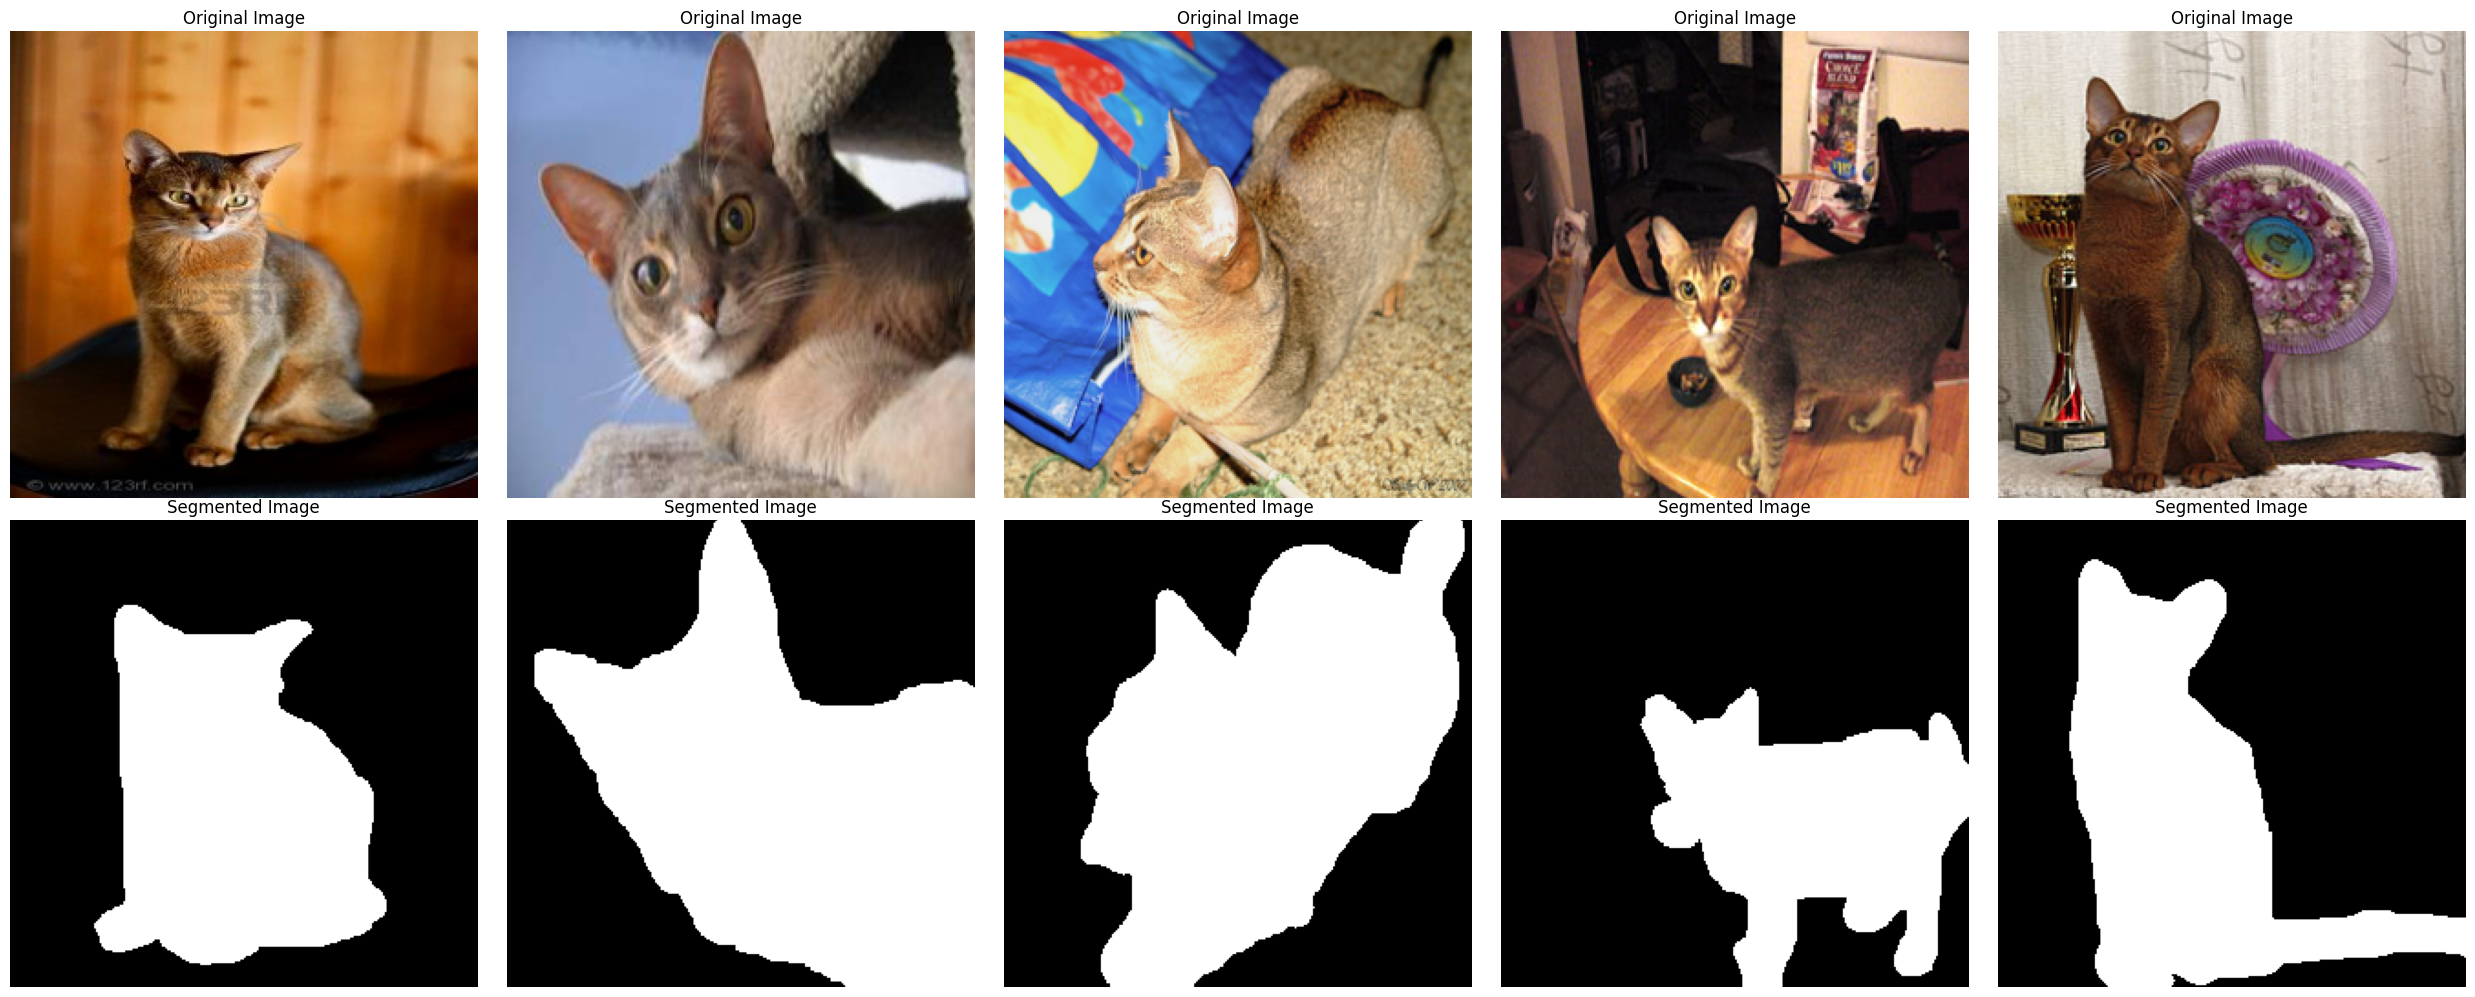

In [4]:
visualize_segmented_image(data, data_segmented, 5, save=True, name="segmented_images", gray=True)

# Pre processing dataset

Normalizando os dados:

In [5]:
data = data.astype('float32') / 255.0

num_classes = len(np.unique(data_segmented))
data_segmented = tf.keras.utils.to_categorical(data_segmented, num_classes=num_classes)

Dividing between train and test:

In [6]:
data_train, data_test, segmentation_train, segmentation_test = train_test_split(data, data_segmented, test_size=0.2, random_state=42)

Verifing data:

In [7]:
print(data.shape)
print(data_segmented.shape)

(199, 256, 256, 3)
(199, 256, 256, 2)


# Creating model

Model:

In [8]:
def unet_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder (Downsampling)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)

    # Decoder (Upsampling)
    u1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    u1 = layers.concatenate([u1, c3])
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u2 = layers.concatenate([u2, c2])
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

    u3 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u3 = layers.concatenate([u3, c1])
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u3)
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c7)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

: 

# Training

In [ ]:
input_shape = data.shape[1:]  # (height, width, channels)
num_classes = data_segmented.shape[-1]  # Número de classes de segmentação

model = unet_model(input_shape, num_classes)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(data_train, segmentation_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


/home/lorran/github/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


# Testing and viewing results

In [ ]:
loss, accuracy = model.evaluate(data_test, segmentation_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

In [ ]:
def visualize_predictions(data_test, segmentation_test, model, num_images=5):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        index = np.random.randint(0, len(data_test))
        
        # Imagem original
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(data_test[index])
        plt.title("Original Image")
        plt.axis("off")
        
        # Segmentação verdadeira
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(np.argmax(segmentation_test[index], axis=-1), cmap='gray')
        plt.title("True Segmentation")
        plt.axis("off")
        
        # Segmentação prevista
        prediction = model.predict(np.expand_dims(data_test[index], axis=0))
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(np.argmax(prediction[0], axis=-1), cmap='gray')
        plt.title("Predicted Segmentation")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Visualizar os resultados
visualize_predictions(data_test, segmentation_test, model)